In [1]:
import os
import cv2
import numpy as np
from collections import Counter
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, TimeDistributed, GlobalAveragePooling2D, Bidirectional, LSTM,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt


In [2]:
DATASET_PATH = r"C:\Users\Akshansh\Desktop\harsh_project\dataset\Adjectives1"  # Change this if different
FRAME_SIZE = (128, 128)
NUM_FRAMES = 20
NUM_CLASSES = 8

In [3]:
# Helper function to load frames from a video
def load_video_frames(video_path, num_frames=NUM_FRAMES, frame_size=FRAME_SIZE):
    cap = cv2.VideoCapture(video_path)
    frames = []
    
    while len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0  # Normalize
        frames.append(frame)

    cap.release()

    # Pad with black frames if needed
    while len(frames) < num_frames:
        frames.append(np.zeros((frame_size[1], frame_size[0], 3)))

    return np.array(frames[:num_frames], dtype=np.float32)

# Label mapping
label_names = sorted(os.listdir(DATASET_PATH))
label_to_index = {label: idx for idx, label in enumerate(label_names)}

print("Label mapping:", label_to_index)

# Load all videos and labels
videos = []
labels = []

for label in label_names:
    label_folder = os.path.join(DATASET_PATH, label)
    for video_file in os.listdir(label_folder):
        if video_file.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
            video_path = os.path.join(label_folder, video_file)
            frames = load_video_frames(video_path)
            videos.append(frames)
            labels.append(label_to_index[label])

# Convert to numpy arrays
X_data = np.array(videos, dtype=np.float32)
Y_data = to_categorical(np.array(labels), num_classes=len(label_names))

print("X_data shape:", X_data.shape)
print("Y_data shape:", Y_data.shape)


Label mapping: {'1. loud': 0, '2. quiet': 1, '3. happy': 2, '4. sad': 3, '5. Beautiful': 4, '6. Ugly': 5, '7. Deaf': 6, '8. Blind': 7}
X_data shape: (381, 20, 128, 128, 3)
Y_data shape: (381, 8)


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)


In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X_data, Y_data, test_size=0.2, random_state=42, stratify=labels
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")


Training samples: 304
Validation samples: 77


In [6]:
def build_custom_model(input_shape, num_classes):
    video_input = Input(shape=input_shape)  # (20, 128, 128, 3)

    # CNN layers inside TimeDistributed
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(video_input)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)

    x = TimeDistributed(Flatten())(x)

    # BiLSTM for sequence modeling
    x = Bidirectional(LSTM(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))(x)

    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=video_input, outputs=output)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy']
    )

    return model


In [7]:
input_shape = (NUM_FRAMES, FRAME_SIZE[1], FRAME_SIZE[0], 3)  # (20, 128, 128, 3)
model = build_custom_model(input_shape, num_classes=NUM_CLASSES)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 128, 128, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 20, 128, 128, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 64, 64, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 64, 64, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 32, 32, 64)   0     

In [8]:
history =model.fit(X_train, Y_train, 
          validation_data=(X_val, Y_val), 
          epochs=100, 
          batch_size=4)

Epoch 1/100
76/76 [==============================] - 35s 290ms/step - loss: 2.0076 - accuracy: 0.1875 - val_loss: 1.5206 - val_accuracy: 0.2727
Epoch 2/100
76/76 [==============================] - 19s 252ms/step - loss: 1.5039 - accuracy: 0.2632 - val_loss: 1.3947 - val_accuracy: 0.2727
Epoch 3/100
76/76 [==============================] - 19s 252ms/step - loss: 1.4837 - accuracy: 0.2697 - val_loss: 1.4248 - val_accuracy: 0.2727
Epoch 4/100
76/76 [==============================] - 19s 255ms/step - loss: 1.4412 - accuracy: 0.2763 - val_loss: 1.3467 - val_accuracy: 0.2987
Epoch 5/100
76/76 [==============================] - 19s 249ms/step - loss: 1.4348 - accuracy: 0.2533 - val_loss: 1.3630 - val_accuracy: 0.2857
Epoch 6/100
76/76 [==============================] - 19s 248ms/step - loss: 1.3386 - accuracy: 0.3257 - val_loss: 1.2003 - val_accuracy: 0.3506
Epoch 7/100
76/76 [==============================] - 19s 247ms/step - loss: 1.0761 - accuracy: 0.4770 - val_loss: 0.9197 - val_accuracy:

In [9]:
model.save('sign_language_model_include50_best.h5')


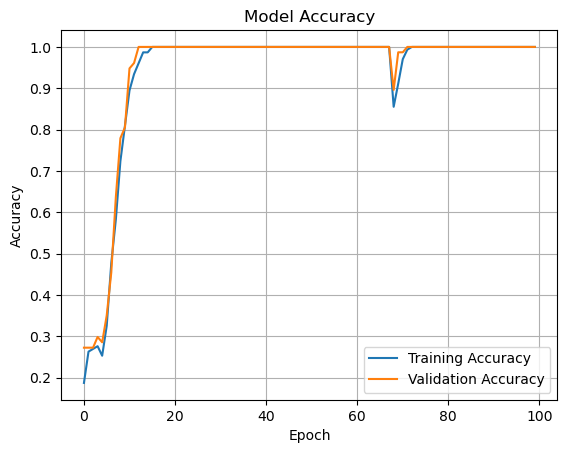

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig("accuracy_graph.png")
plt.show()


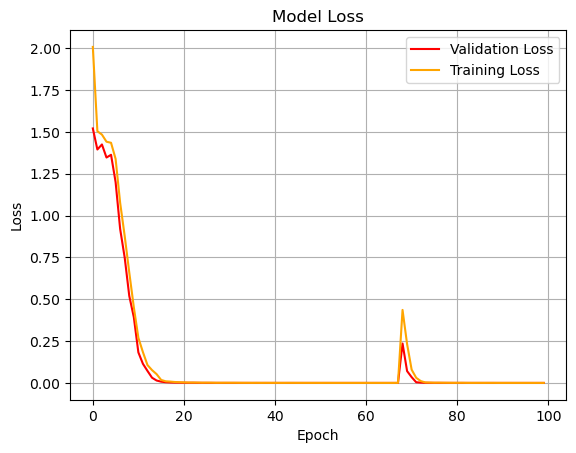

In [15]:
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("accuracy_loss_graph.png")
plt.show()


3/3 [==============================] - 1s 97ms/step


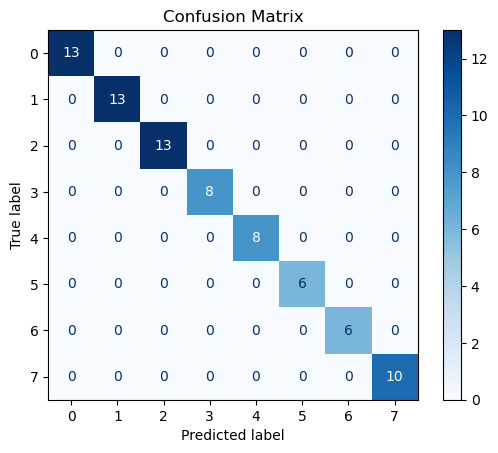

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
# Predict probabilities
y_pred_probs = model.predict(X_val)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# If your true labels are one-hot encoded, convert them too
y_true = np.argmax(Y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
labels = list(range(cm.shape[0]))  # or use class names if available

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig("confussion_matrix.png")
plt.show()


In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pickle


In [4]:
model = load_model(r"E:\final_work\include_50\programs\sign_language_model_include50_best.h5")


TypeError: Could not locate class 'Conv2D'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Input, GlobalAveragePooling2D, BatchNormalization

# Load model with custom objects
model = load_model(r"E:\final_work\include_50\programs\sign_language_model_include50_best.h5", custom_objects={
    'Conv2D': Conv2D,
    'MaxPooling2D': MaxPooling2D,
    'Flatten': Flatten,
    'Dense': Dense,
    'Dropout': Dropout,
    'LSTM': LSTM,
    'TimeDistributed': TimeDistributed,
    'Input': Input,
    'GlobalAveragePooling2D': GlobalAveragePooling2D,
    'BatchNormalization': BatchNormalization,
})


ValueError: Unrecognized keyword arguments passed to LSTM: {'time_major': False}